In [1]:
import os
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import noisereduce as nr
import pywt
import warnings
from tqdm import tqdm
from joblib import Parallel, delayed
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import jiwer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Masking, LSTM, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import time
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from scipy.signal import butter, sosfiltfilt

warnings.filterwarnings('ignore')


c:\Users\gabry\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SAMPLE_RATE = 16000
N_MFCC = 13
N_MELS = 22
WINDOW = int(SAMPLE_RATE * 0.01)
HOP = int(SAMPLE_RATE * 0.005)
COMMANDS = ["baca", "berhenti", "foto", "halo", "info", "kembali", "ulang"]


In [3]:
def load_audio(file_path, sr=SAMPLE_RATE):
    audio, _ = librosa.load(file_path, sr=sr)
    return audio / np.max(np.abs(audio))

def bandpass_filter(audio, lowcut=300, highcut=3400, sr=SAMPLE_RATE, order=5):
    sos = butter(order, [lowcut, highcut], btype='band', fs=sr, output='sos')
    return sosfiltfilt(sos, audio)

def reduce_noise(audio):
    return nr.reduce_noise(y=audio, sr=SAMPLE_RATE)

def preprocess_audio(file_path):
    audio = load_audio(file_path)
    audio = bandpass_filter(audio)
    return reduce_noise(audio)

def extract_mfcc(signal):
    return librosa.feature.mfcc(
        y=signal,  
        sr=SAMPLE_RATE,
        n_mfcc=N_MFCC,
        n_mels=N_MELS,
        n_fft=WINDOW,
        hop_length=HOP
    ).T

In [4]:
def load_dataset(directory, commands):
    data = []
    for label in commands:
        folder = os.path.join(directory, label)
        for file in os.listdir(folder):
            if file.endswith('.wav'):
                data.append((os.path.join(folder, file), label))
    return pd.DataFrame(data, columns=["speech", "label"])


In [5]:
def extract_features(df):
    print("Preprocessing and extracting features...")
    features = Parallel(n_jobs=-1)(
        delayed(lambda path: extract_mfcc(preprocess_audio(path)))(fp)
        for fp in tqdm(df['speech'], desc="Extracting")
    )
    df['mfcc'] = features
    return df


In [6]:
def encode_and_pad(df_train, df_valid):
    le = LabelEncoder()
    df_train['label_encoded'] = le.fit_transform(df_train['label'])
    df_valid['label_encoded'] = le.transform(df_valid['label'])

    all_mfcc = df_train['mfcc'].tolist() + df_valid['mfcc'].tolist()
    max_len = max(len(x) for x in all_mfcc)

    X_train = pad_sequences(df_train['mfcc'], maxlen=max_len, padding='post', dtype='float32')
    X_valid = pad_sequences(df_valid['mfcc'], maxlen=max_len, padding='post', dtype='float32')

    y_train = to_categorical(df_train['label_encoded'])
    y_valid = to_categorical(df_valid['label_encoded'])

    return X_train, y_train, X_valid, y_valid, le


In [7]:
def build_model(input_shape, num_classes):
    model = Sequential([
        Masking(mask_value=0.0, input_shape=input_shape),
        LSTM(128, return_sequences=True),
        GlobalAveragePooling1D(),
        Dense(64, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [8]:
def train_model(model, X_train, y_train, X_valid, y_valid, batch_size=32, epochs=100):
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=1
    )
    return model, history


In [9]:
def evaluate_model(model, X_valid, y_valid, label_encoder):
    # Mulai timer
    start = time.time()
    
    # Predict
    y_pred_probs = model.predict(X_valid)
    end = time.time()
    
    # Konversi ke kelas
    y_pred_classes = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_valid, axis=1)
    
    # Classification Report
    print("\n=== Classification Report ===")
    print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))
    
    # RTF (Real Time Factor) - asumsi 16 kHz
    audio_duration_total = (X_valid.shape[0] * X_valid.shape[1]) / 16000
    rtf = (end - start) / audio_duration_total
    print(f"RTF (Real Time Factor): {rtf:.4f}")
    
    # Precision, Recall, F1 Score (weighted)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    
    print(f"Precision (weighted): {precision:.4f}")
    print(f"Recall (weighted): {recall:.4f}")
    print(f"F1 Score (weighted): {f1:.4f}")
    
    return {
        'RTF': rtf,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'y_true': y_true,
        'y_pred': y_pred_classes
    }


In [10]:
# Load datasets
df_train = load_dataset("dataaug/training", COMMANDS)
df_valid = load_dataset("dataaug/validation", COMMANDS)

In [11]:
# Preprocessing + Feature extraction
df_train = extract_features(df_train)
df_valid = extract_features(df_valid)


Preprocessing and extracting features...


Extracting: 100%|██████████| 13489/13489 [02:40<00:00, 84.06it/s]


Preprocessing and extracting features...


Extracting: 100%|██████████| 1290/1290 [00:14<00:00, 91.52it/s]


In [12]:
df_train['label'].value_counts()

label
kembali     1960
ulang       1932
baca        1925
foto        1925
berhenti    1918
info        1918
halo        1911
Name: count, dtype: int64

In [13]:
df_valid['label'].value_counts()

label
kembali     188
baca        184
berhenti    184
foto        184
ulang       184
halo        183
info        183
Name: count, dtype: int64

In [14]:
# Encode & pad
X_train, y_train, X_valid, y_valid, le = encode_and_pad(df_train, df_valid)

In [15]:
# Print the encoding assignment
for label, encoded in zip(le.classes_, range(len(le.classes_))):
    print(f"'{label}' -> {encoded}")

'baca' -> 0
'berhenti' -> 1
'foto' -> 2
'halo' -> 3
'info' -> 4
'kembali' -> 5
'ulang' -> 6


In [16]:
# Build model
model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]), num_classes=y_train.shape[1])

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 929, 13)           0         
                                                                 
 lstm (LSTM)                 (None, 929, 128)          72704     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                        

In [18]:
# Train model
model, history = train_model(model, X_train, y_train, X_valid, y_valid)

Epoch 1/100
422/422 [==============================] - 38s 67ms/step - loss: 1.0617 - accuracy: 0.6498 - val_loss: 0.3084 - val_accuracy: 0.9419
Epoch 2/100
422/422 [==============================] - 28s 65ms/step - loss: 0.2842 - accuracy: 0.9242 - val_loss: 0.1320 - val_accuracy: 0.9620
Epoch 3/100
422/422 [==============================] - 27s 65ms/step - loss: 0.1525 - accuracy: 0.9571 - val_loss: 0.0814 - val_accuracy: 0.9775
Epoch 4/100
422/422 [==============================] - 26s 61ms/step - loss: 0.1050 - accuracy: 0.9712 - val_loss: 0.0586 - val_accuracy: 0.9798
Epoch 5/100
422/422 [==============================] - 26s 62ms/step - loss: 0.0762 - accuracy: 0.9792 - val_loss: 0.0513 - val_accuracy: 0.9868
Epoch 6/100
422/422 [==============================] - 28s 68ms/step - loss: 0.0705 - accuracy: 0.9796 - val_loss: 0.0440 - val_accuracy: 0.9853
Epoch 7/100
422/422 [==============================] - 29s 69ms/step - loss: 0.0537 - accuracy: 0.9848 - val_loss: 0.0415 - val_ac

In [19]:
# val_accuracy terbaik
best_val_acc = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1  
print(f"Val accuracy terbaik: {best_val_acc:.4f} pada epoch ke-{best_epoch}")

Val accuracy terbaik: 0.9946 pada epoch ke-12


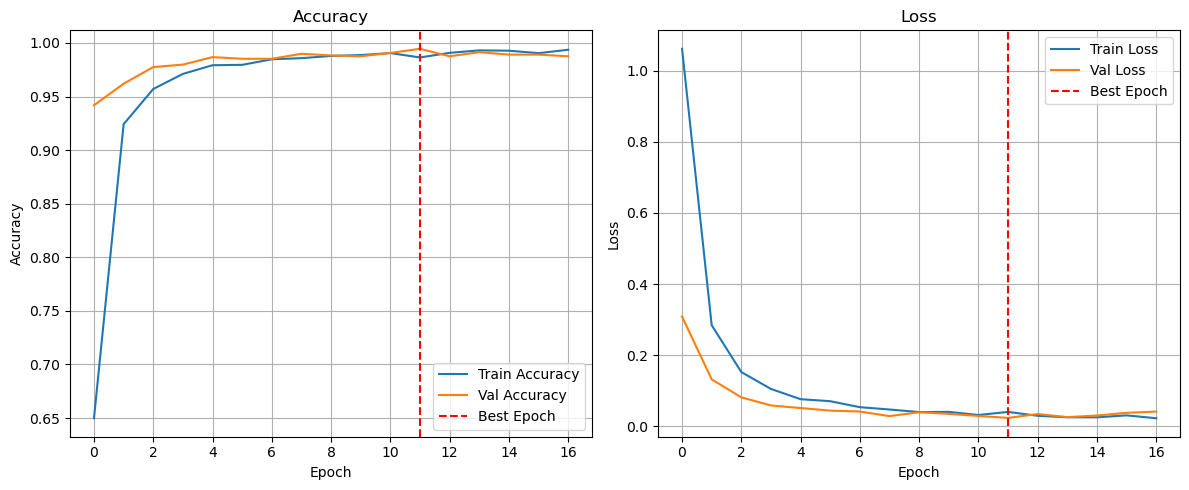

In [20]:
# Grafik akurasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Grafik loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.axvline(best_epoch-1, color='r', linestyle='--', label='Best Epoch')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [21]:
#Evaluasi
metrics = evaluate_model(model, X_valid, y_valid, le)


41/41 [==============================] - 2s 23ms/step

=== Classification Report ===
              precision    recall  f1-score   support

        baca       0.99      0.99      0.99       184
    berhenti       1.00      1.00      1.00       184
        foto       0.99      0.99      0.99       184
        halo       0.99      0.99      0.99       183
        info       0.99      0.99      0.99       183
     kembali       1.00      0.99      1.00       188
       ulang       0.98      0.99      0.99       184

    accuracy                           0.99      1290
   macro avg       0.99      0.99      0.99      1290
weighted avg       0.99      0.99      0.99      1290

RTF (Real Time Factor): 0.0293
Precision (weighted): 0.9946
Recall (weighted): 0.9946
F1 Score (weighted): 0.9946


In [22]:
model.save('model/mymodelk3.h5')

# Testing

In [23]:
# Load model
modeltes = load_model('model/mymodelk3.h5')

In [24]:
# Inisialisasi
y_true, y_pred = [], []
dataset_path = 'datasetuji'

In [25]:
# load audio
all_mfcc = []
for label in COMMANDS:
    folder_path = os.path.join(dataset_path, label)
    for filename in os.listdir(folder_path):
        if filename.endswith('.wav'):
            file_path = os.path.join(folder_path, filename)
            signal = preprocess_audio(file_path)
            mfcc = extract_mfcc(signal)
            all_mfcc.append(mfcc)


max_len = 929  

# preprocessing
y_true = []
y_pred = []
for label, mfcc in zip(
    [label for label in COMMANDS for filename in os.listdir(os.path.join(dataset_path, label)) if filename.endswith('.wav')],
    all_mfcc
):
    # Pad the MFCC sequence to the fixed max_len
    x_input = pad_sequences([mfcc], maxlen=max_len, padding='post', dtype='float32')

    # Make prediction
    prediction = modeltes.predict(x_input)
    pred_label_idx = np.argmax(prediction, axis=1)[0]  # Ensure scalar index

    # Append true and predicted labels
    y_true.append(COMMANDS.index(label))
    y_pred.append(pred_label_idx)

1/1 [==============================] - 0s 47ms/step


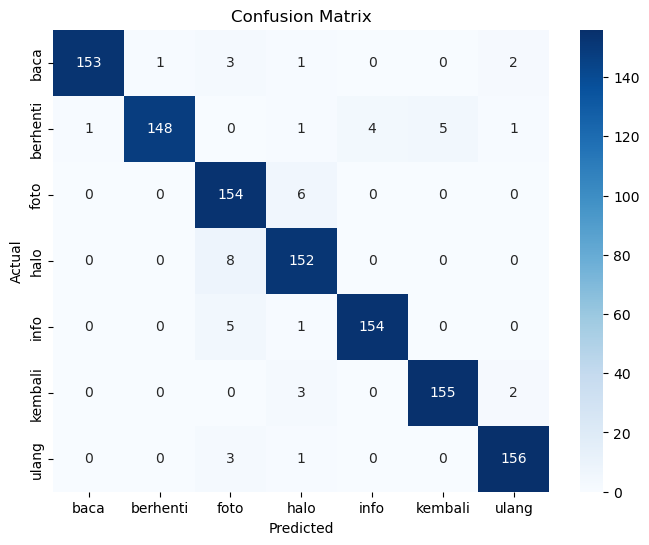

              precision    recall  f1-score   support

        baca       0.99      0.96      0.97       160
    berhenti       0.99      0.93      0.96       160
        foto       0.89      0.96      0.92       160
        halo       0.92      0.95      0.94       160
        info       0.97      0.96      0.97       160
     kembali       0.97      0.97      0.97       160
       ulang       0.97      0.97      0.97       160

    accuracy                           0.96      1120
   macro avg       0.96      0.96      0.96      1120
weighted avg       0.96      0.96      0.96      1120



In [26]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=COMMANDS, yticklabels=COMMANDS)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_true, y_pred, target_names=COMMANDS)
print(report)

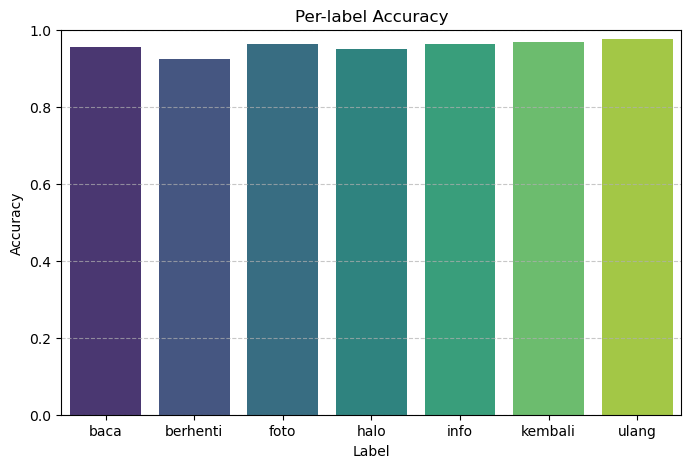

In [27]:
# Akurasi per Label
correct_per_label = np.diag(cm) 
total_per_label = np.sum(cm, axis=1)
accuracy_per_label = correct_per_label / total_per_label

# Bar Chart Akurasi per Label
plt.figure(figsize=(8, 5))
sns.barplot(x=COMMANDS, y=accuracy_per_label, palette='viridis')
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.xlabel('Label')
plt.title('Per-label Accuracy')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
